## **Network Analysis for intrusion detection**
###An implementation by Python

Import libraries:

In [88]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import math
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow import test
import matplotlib.pyplot as plt

Plot some activation functions:

ReLu:

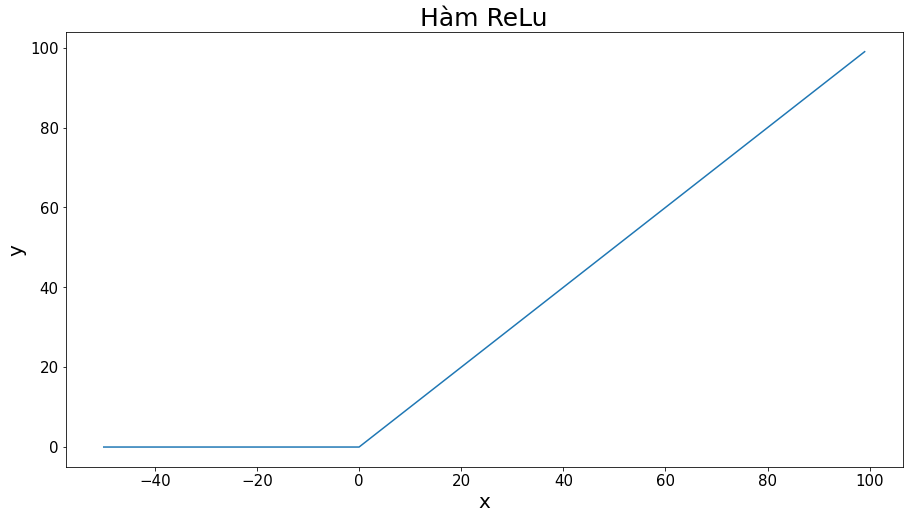

In [89]:
def rectified(x):
	return max(0.0, x)
 

series_in = [x for x in range(-50, 100)]
series_out = [rectified(x) for x in series_in]
plt.rcParams["figure.figsize"] = (15,8)
plt.plot(series_in, series_out)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Hàm ReLu', fontsize=25)
plt.xlabel('x', fontsize=20)
plt.ylabel('y', fontsize=20)
plt.show()

Sigmoid

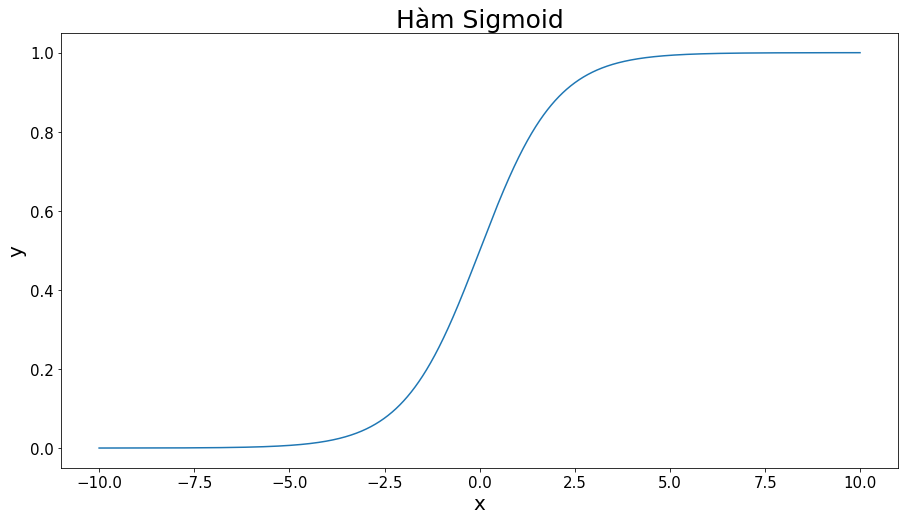

In [90]:
def sigmoid(x):
  return 1 / (1 + math.exp(-x))

series_in = [float(x) for x in np.arange(-10, 10, 0.01)]
series_out = [sigmoid(x) for x in series_in]
plt.rcParams["figure.figsize"] = (15,8)
plt.plot(series_in, series_out)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Hàm Sigmoid', fontsize=25)
plt.xlabel('x', fontsize=20)
plt.ylabel('y', fontsize=20)
plt.show()


Softmax:

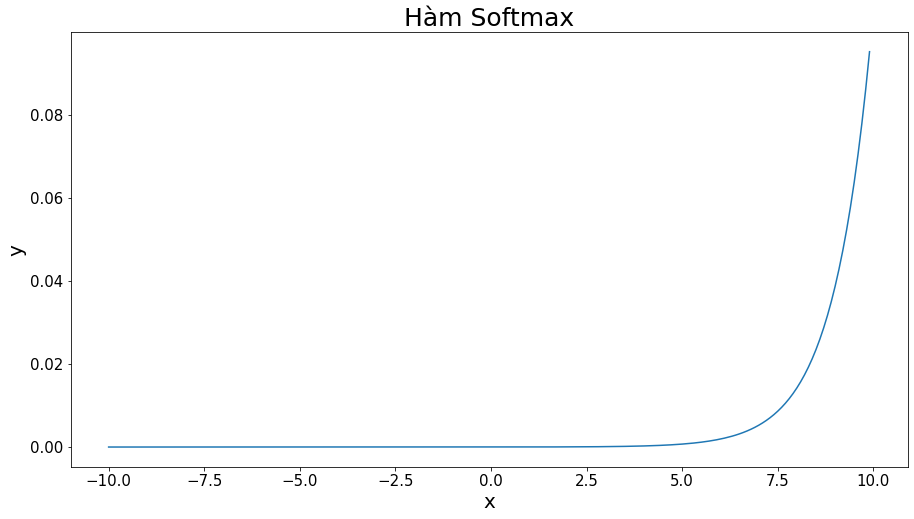

In [91]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

series_in = np.arange(-10, 10, 0.1)
series_out = softmax(series_in)
plt.rcParams["figure.figsize"] = (15,8)
plt.plot(series_in, series_out)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Hàm Softmax', fontsize=25)
plt.xlabel('x', fontsize=20)
plt.ylabel('y', fontsize=20)
plt.show()

Download the dataset from GitHub. They are available [here](https://github.com/defcom17/NSL_KDD).

In [92]:
!wget -O KDDTrain+.csv https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTrain%2B.csv  # NSL_KDD Train
!wget -O Small_Training_Set.csv https://raw.githubusercontent.com/defcom17/NSL_KDD/master/Small%20Training%20Set.csv  # Small Training Set
!wget -O KDDTest+.csv https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTest%2B.csv  # NSL_KDD Test

--2020-06-20 13:28:34--  https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTrain%2B.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14612857 (14M) [text/plain]
Saving to: ‘KDDTrain+.csv’

KDDTrain+.csv       100%[===================>]  13.94M  23.9MB/s    in 0.6s    

2020-06-20 13:28:35 (23.9 MB/s) - ‘KDDTrain+.csv’ saved [14612857/14612857]

--2020-06-20 13:28:37--  https://raw.githubusercontent.com/defcom17/NSL_KDD/master/Small%20Training%20Set.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 117304 (115K) [text/plain]


Fix random outcomes:

In [93]:
#np.random.seed(7)

Test GPU benchmarks:

In [94]:
gpu_test = test.gpu_device_name()
if test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

No GPU found


## 1. Data loading and preprocessing

### 1.1. Data loading

Data loading function to Pandas dataframe. Available `filename` are: `Small_Training_Set.csv`, `KDDTrain+.csv`, `KDDTest+.csv`.


In [95]:
def load_file(filename):
    # Small_Training_Set.csv
    # KDDTrain+.csv
    # KDDTest+.csv
    df = pd.read_csv(filename,
                     names = ["duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", "land",
                              "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in", "num_compromised",
                              "root_shell", "su_attempted", "num_root", "num_file_creations", "num_shells",
                              "num_access_files", "num_outbound_cmds", "is_host_login", "is_guest_login", "count",
                              "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate",
                              "srv_rerror_rate", "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate", "dst_host_count",
                              "dst_host_srv_count", "dst_host_same_srv_rate", "dst_host_diff_srv_rate","dst_host_same_src_port_rate",
                              "dst_host_srv_diff_host_rate", "dst_host_serror_rate",
                              "dst_host_srv_serror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate",
                              "label", "score"])
    df = df.dropna(inplace=False)  # Drop missing value
    # df = df.sample(frac=1).reset_index(drop=True)  # Shuffle the dataset
    return df

Run the functions:

In [96]:
# Load training dataset
# Available dataset: Small_Training_Set.csv, KDDTrain+.csv, KDDTest+.csv
df_train = load_file('KDDTrain+.csv')
df_test = load_file('KDDTest+.csv')

Visualization and reporting


In [97]:
print("Training set shape: " + str(df_train.shape))
print("Testing set shape: " + str(df_test.shape))
print("Number of features: " + str(len(df_train.columns) - 2))
print("Number of labels: 2")

Training set shape: (125973, 43)
Testing set shape: (22543, 43)
Number of features: 41
Number of labels: 2


In [98]:
df_train.dtypes


duration                         int64
protocol_type                   object
service                         object
flag                            object
src_bytes                        int64
dst_bytes                        int64
land                             int64
wrong_fragment                   int64
urgent                           int64
hot                              int64
num_failed_logins                int64
logged_in                        int64
num_compromised                  int64
root_shell                       int64
su_attempted                     int64
num_root                         int64
num_file_creations               int64
num_shells                       int64
num_access_files                 int64
num_outbound_cmds                int64
is_host_login                    int64
is_guest_login                   int64
count                            int64
srv_count                        int64
serror_rate                    float64
srv_serror_rate          

### 1.2. Data preprocessing

One-hot-encoding function:

In [99]:
def one_hot_encode(df, feature):
    loc_last_column = len(df.columns)
    loc_insert = df.columns.get_loc(feature)  # Get original index of the first categorical columns in df
    # drop_first: Make one of the feature goes [0,0,0,...0]
    added_cols = pd.get_dummies(df[feature], prefix=feature, drop_first=True)
    df = pd.concat([df, added_cols], axis=1, sort=False)

    # Move the added one-hot columns to their original index
    moved_df = df[df.columns[loc_last_column:]] # Added one-hot columns
    cols_df = df.columns.tolist()
    cols_features = moved_df.columns.tolist()
    for (count, col_feature) in enumerate(cols_features):
        cols_df.insert(loc_insert + count, cols_df.pop(cols_df.index(col_feature)))
        df = df.reindex(columns=cols_df)

  # Delete categorical columns after being one-hot-encoded
    df.drop([feature], axis=1, inplace=True)
    return df

Label-encoding function:

In [100]:
def label_encode(df, feature):
    df[feature] = df[feature].astype('category').cat.codes
    return df

Classify the label (22 features) into five categories:

- Normal Traffic
- DoS attack
- Probing attack
- User-to-Root (Privilege Escalation) attack
- Remote-to-Local (Exploitation) attack

In [101]:
def classify_label(row):
    normal = ['normal']
    dos = ['apache2', 'back', 'land', 'neptune', 'mailbomb', 'pod', 'processtable', 'smurf', 'teardrop', 'udpstorm', 'worm']
    probe = ['ipsweep', 'mscan', 'nmap', 'portsweep', 'saint', 'satan']
    u2r = ['buffer_overflow', 'loadmodule', 'perl', 'ps', 'rootkit', 'sqlattack', 'xterm']
    r2l = ['ftp_write', 'guess_passwd', 'httptunnel', 'imap', 'multihop', 'named',
           'phf', 'sendmail', 'snmpgetattack', 'spy', 'snmpguess', 'warezclient', 'warezmaster', 'xlock', 'xsnoop']

    if row['label'].lower() in normal:
        return 0
    elif row['label'].lower() in dos:
        return 1
    elif row['label'].lower() in probe:
        return 2
    elif row['label'].lower() in u2r:
        return 3
    elif row['label'].lower() in r2l:
        return 4
    else:
        return 5

Visualize the labels before label-encoding:

In [102]:
label_train = df_train['label'].value_counts()
print(label_train)

normal             67343
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
loadmodule             9
ftp_write              8
multihop               7
phf                    4
perl                   3
spy                    2
Name: label, dtype: int64


Text(0, 0.5, 'Số lượng')

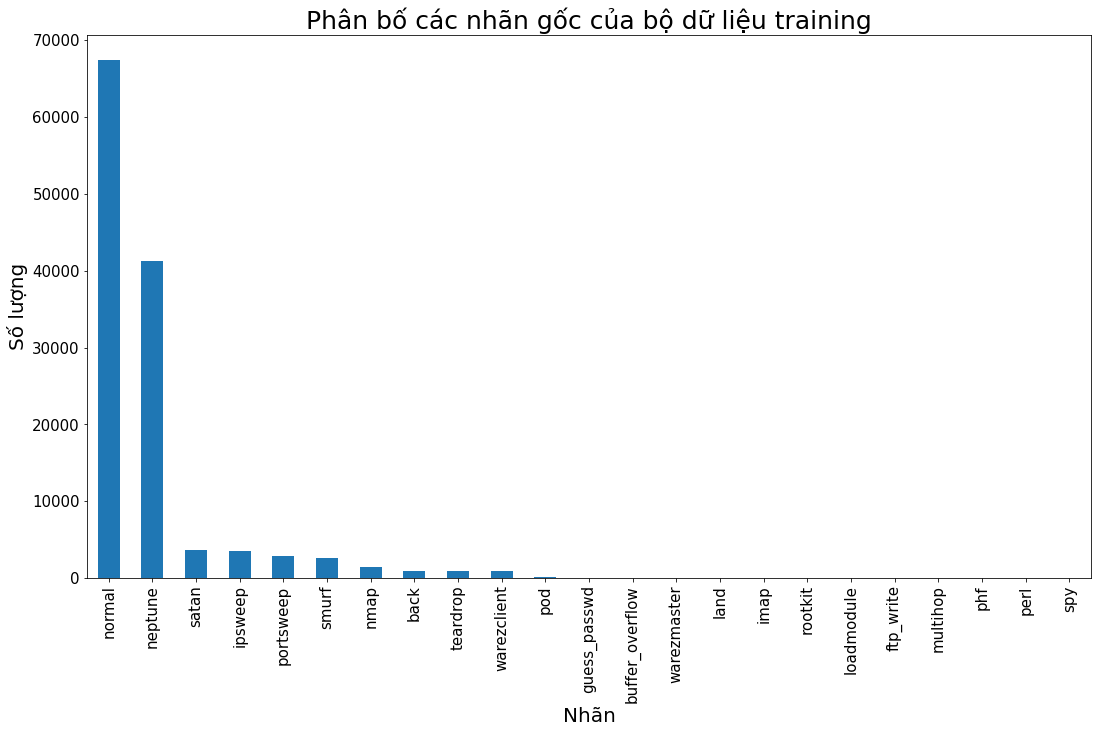

In [103]:
label_train.plot.bar(x="Số lượng", y="Nhãn", figsize=(18,10))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Phân bố các nhãn gốc của bộ dữ liệu training', fontsize=25)
plt.xlabel('Nhãn', fontsize=20)
plt.ylabel('Số lượng', fontsize=20)


In [104]:
label_test = df_test['label'].value_counts()
print(label_test)

normal             9710
neptune            4657
guess_passwd       1231
mscan               996
warezmaster         944
apache2             737
satan               735
processtable        685
smurf               665
back                359
snmpguess           331
saint               319
mailbomb            293
snmpgetattack       178
portsweep           157
ipsweep             141
httptunnel          133
nmap                 73
pod                  41
buffer_overflow      20
multihop             18
named                17
ps                   15
sendmail             14
xterm                13
rootkit              13
teardrop             12
xlock                 9
land                  7
xsnoop                4
ftp_write             3
loadmodule            2
worm                  2
sqlattack             2
udpstorm              2
perl                  2
phf                   2
imap                  1
Name: label, dtype: int64


Text(0, 0.5, 'Số lượng')

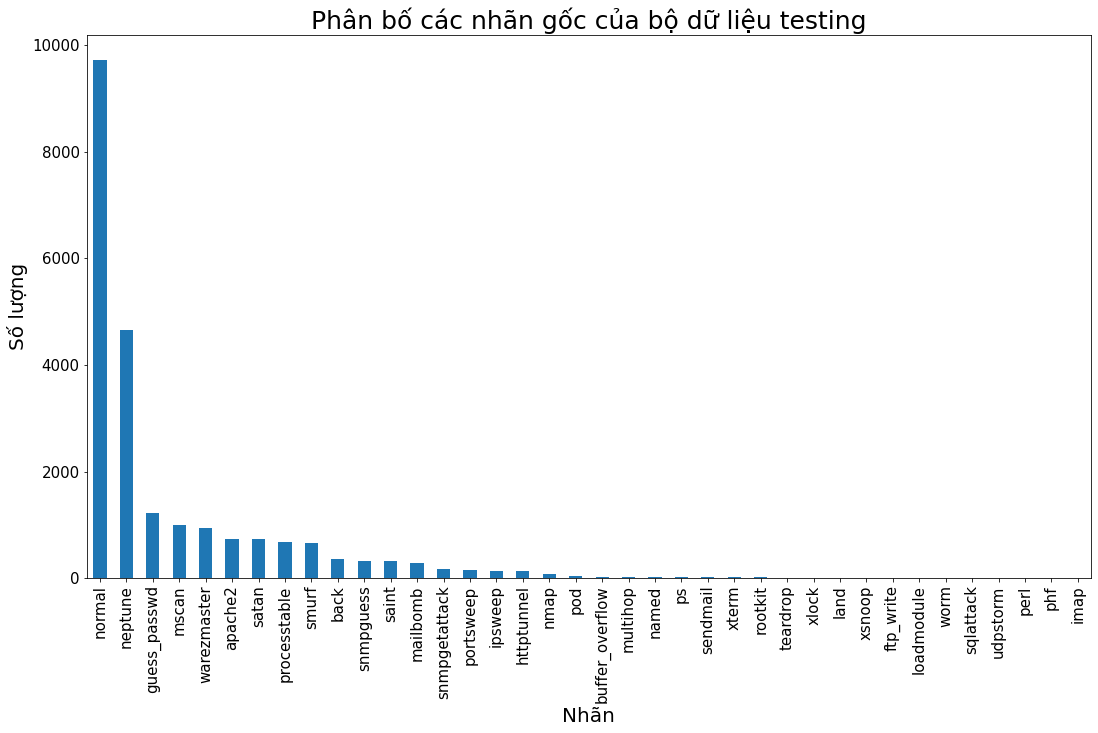

In [105]:
label_test.plot.bar(x="Số lượng", y="Nhãn", figsize=(18,10))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Phân bố các nhãn gốc của bộ dữ liệu testing', fontsize=25)
plt.xlabel('Nhãn', fontsize=20)
plt.ylabel('Số lượng', fontsize=20)

Encode the dataset.

In [106]:
def encode(df, one_hot_features=None, label_encoded_features=None):
    # One hot encoding for categorical features: protocol_type, service, flag
    if one_hot_features != None:
        for feature in one_hot_features:
            df = one_hot_encode(df, feature)

    # Label encoding for categorical features: protocol_type, service, flag
    if label_encoded_features != None:
        for feature in label_encoded_features:
            df = label_encode(df, feature)

  # Encode label
    df['attack_type'] = df.apply(lambda row: classify_label(row), axis='columns')

    # Drop unused label columns
    df = df.drop('score', axis='columns')
    df = df.drop('label', axis='columns')
    return df

Run the functions:

In [107]:
print('Encoding dataset...')
# Encode categorical features into numeric
# Categorical features: protocol_type, service, flag
df_train = encode(df_train, label_encoded_features=['protocol_type', 'service', 'flag'])
df_test = encode(df_test, label_encoded_features=['protocol_type', 'service', 'flag'])

Encoding dataset...


Visualizing the label distribution of the dataset

In [108]:
attack_type_train = df_train['attack_type'].value_counts()
print(attack_type_train)

0    67343
1    45927
2    11656
4      995
3       52
Name: attack_type, dtype: int64


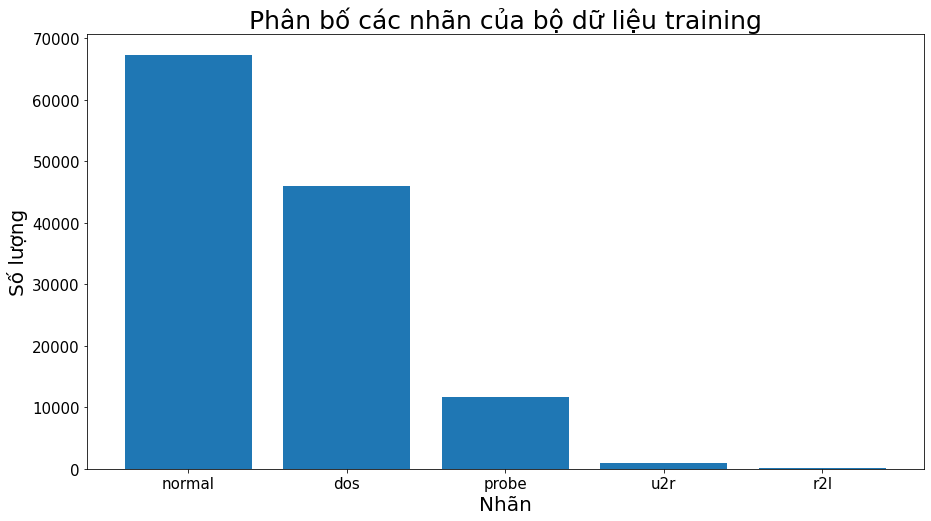

In [109]:
index = ['normal', 'dos', 'probe', 'u2r', 'r2l']
#attack_type.plot.bar(x="Số lượng", y="Nhãn", figsize=(18,10))
plt.bar(index, attack_type_train)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Phân bố các nhãn của bộ dữ liệu training', fontsize=25)
plt.xlabel('Nhãn', fontsize=20)
plt.ylabel('Số lượng', fontsize=20)
    
#plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [110]:
attack_type_test = df_test['attack_type'].value_counts()
print(attack_type_test)

0    9710
1    7460
4    2885
2    2421
3      67
Name: attack_type, dtype: int64


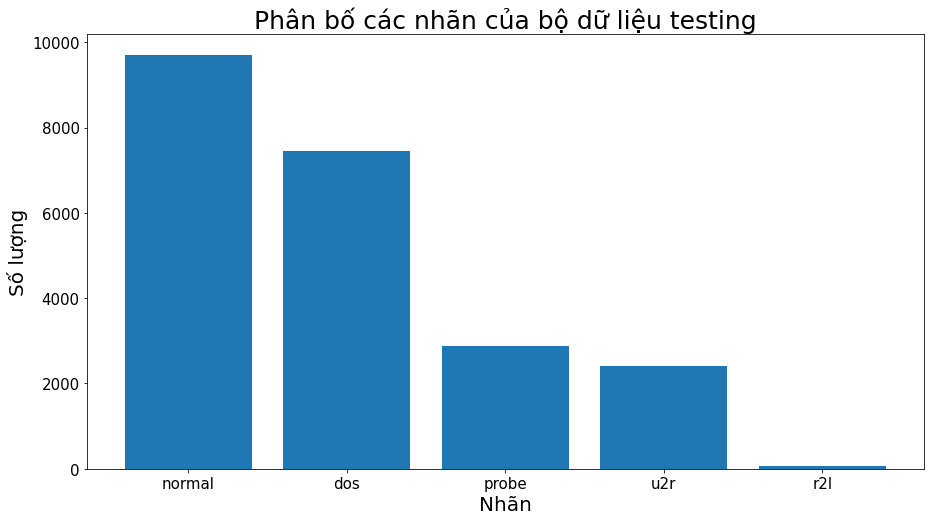

In [111]:
index = ['normal', 'dos', 'probe', 'u2r', 'r2l']
#attack_type.plot.bar(x="Số lượng", y="Nhãn", figsize=(18,10))
plt.bar(index, attack_type_test)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Phân bố các nhãn của bộ dữ liệu testing', fontsize=25)
plt.xlabel('Nhãn', fontsize=20)
plt.ylabel('Số lượng', fontsize=20)
    
#plt.legend(['train', 'test'], loc='upper left')
plt.show()

Normalize the dataset:

In [112]:
def normalize(df):
    # Normalize all columns except the last one
    scaler = MinMaxScaler()
    df[df.columns[:-1]] = scaler.fit_transform(df[df.columns[:-1]])
    return df
    '''
    y = df['attack_type']  # Label # Series
    X = df.drop(['attack_type'], axis='columns')  # Features # Dataframe
    X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.2)
    return X_train, X_validate, y_train, y_validate
    '''

Run the functions:

In [113]:
print('Normalizing and spliting training data for feature extracion...')
# Split training and validation data
df_train = normalize(df_train)
y = df_train['attack_type']  # Label # Series
X = df_train.drop(['attack_type'], axis='columns')  # Features # Dataframe
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.2)
all_features = X_train.columns.tolist()

print("X_train shape: " + str(X_train.shape))
print("y_train shape: " + str(y_train.shape))
print("X_validate shape: " + str(X_validate.shape))
print("y_validate shape: " + str(y_validate.shape))

Normalizing and spliting training data for feature extracion...
X_train shape: (100778, 41)
y_train shape: (100778,)
X_validate shape: (25195, 41)
y_validate shape: (25195,)


Split the training dataset into training and validation set:




In [114]:
# Split the dataset into training and test set
def split_data(df, test_size=0.2):
    test_samples = int(len(df) * test_size)
    train_samples = len(df) - test_samples
    train = df.iloc[0:train_samples,:]
    test = df.iloc[train_samples:len(df),:]
    return train, test

## 2. Feature extraction

Extract important features using Extra Tree or Random Forest.

In [115]:
def pick_important_features(number_of_features, columns, feature_importance_normalized):
    # feature_importance_normalized: numpy.ndarray: Important factor from extra_tree.fit or random_forest.fit
    top_index = np.argpartition(feature_importance_normalized, -number_of_features)[-number_of_features:] # Return indexes of max-valued importance
    top_columns = []
    top_score = feature_importance_normalized[top_index]
    for i in top_index:
        top_columns.append(columns[i])
    '''
    index_order = np.argsort(top_score)[::-1]  # Return descending top score index
    with open('{}/results/most_important_features.txt'.format(settings.root), 'w') as f:
        for i in index_order:
            print(top_columns[i] + ":" + str(top_score[i]), file=f)
    '''
    return top_columns, top_score

Extra Tree function to choose the most important features:

In [116]:
# Reference: https://www.geeksforgeeks.org/ml-extra-tree-classifier-for-feature-selection/
def extract_extra_tree(X_train, y_train, number_of_features=18):
    extra_tree = ExtraTreesRegressor(n_estimators=100)
    extra_tree.fit(X_train, y_train)
    feature_importance_normalized = np.std([tree.feature_importances_ for tree
                                            in extra_tree.estimators_],
                                           axis=0)  # numpy.ndarray
    top_columns, top_score = pick_important_features(number_of_features,
                                                     X_train.columns.tolist(),
                                                     feature_importance_normalized)
    return top_columns, top_score

Random Forest function to choose the most important features:

In [117]:
def extract_random_forest(X_train, y_train, number_of_features=18):
    random_forest = RandomForestRegressor(n_estimators=100)
    random_forest.fit(X_train, y_train)
    feature_importance_normalized = np.std([tree.feature_importances_ for tree
                                            in random_forest.estimators_],
                                           axis=0)  # numpy.ndarray
    top_columns, top_score = pick_important_features(number_of_features,
                                                     X_train.columns.tolist(),
                                                     feature_importance_normalized)
    return top_columns, top_score

Extract important features from the dataset:

In [118]:
def create_dataset(df, top_columns):
    top_columns.append('attack_type')
    df = df.drop(df.columns.difference(top_columns), axis=1)
    return df

Run the function:

In [119]:
print('Extracting features by Extra Tree...\n')
# Extract most important features
# top_columns, top_score = extract_random_forest(X_train, y_train, number_of_features=20)
top_columns, top_score = extract_extra_tree(X_train, y_train, number_of_features=25)
for i, elem in enumerate(top_columns):
    print("{}:{}".format(top_columns[i], top_score[i]))

Extracting features by Extra Tree...

duration:0.006747209265732076
logged_in:0.10375105042882417
hot:0.013476503017688242
dst_bytes:0.014354801634397153
protocol_type:0.04342677031622612
is_guest_login:0.008948323573687213
count:0.006917177008407434
src_bytes:0.014012427050116275
serror_rate:0.012787752533592498
srv_serror_rate:0.010988112785905021
rerror_rate:0.012984805543591955
flag:0.018322084857555238
same_srv_rate:0.00840616363730476
diff_srv_rate:0.006950226619388066
srv_diff_host_rate:0.011122185895343825
dst_host_count:0.01316712362883443
dst_host_srv_count:0.11916562841599751
dst_host_same_srv_rate:0.02060917293127813
dst_host_diff_srv_rate:0.01676846830706356
dst_host_same_src_port_rate:0.03119268406482258
dst_host_srv_diff_host_rate:0.023940683851867896
service:0.015137289844117031
dst_host_srv_serror_rate:0.010597585114800969
dst_host_rerror_rate:0.013930625345400197
dst_host_srv_rerror_rate:0.006894167011185096


In [120]:
print('Creating a new dataset after feature extraction...')
# Create a dataset after feature extraction
# TODO: The dataframe (Pandas) at this step is for training and validation
df_train = create_dataset(df_train, top_columns)  # Training set
print(df_train.columns)

Creating a new dataset after feature extraction...
Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'hot', 'logged_in', 'is_guest_login', 'count',
       'serror_rate', 'srv_serror_rate', 'rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_srv_serror_rate',
       'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'attack_type'],
      dtype='object')


In [121]:
y = df_train['attack_type']  # Label # Series
X = df_train.drop(['attack_type'], axis='columns')  # Features # Dataframe
'''
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.2)
all_features = X_train.columns.tolist()
'''


'\nX_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.2)\nall_features = X_train.columns.tolist()\n'

In [122]:
print("X shape: " + str(X.shape))
print("y shape: " + str(y.shape))

X shape: (125973, 25)
y shape: (125973,)


In [123]:
X.shape[1]

25

## 3. DNN model

**DNN Model:**

In [124]:
'''
def build_dnn():
    model = keras.Sequential()

    model.add(layers.Dense(128, activation = 'relu', input_shape = (20,)))
    model.add(Dropout(0.2))

    model.add(layers.Dense(128, activation = 'relu'))
    model.add(Dropout(0.2))

    model.add(layers.Dense(64, activation = 'relu'))
    model.add(Dropout(0.2))

    model.add(layers.Dense(5, activation = 'softmax'))
    model.compile(loss = 'sparse_categorical_crossentropy',
                    optimizer = keras.optimizers.Adam(),
                    metrics = ['sparse_categorical_accuracy'])
    return model
'''
def build_dnn():
    model = keras.Sequential()

    model.add(layers.Dense(1024, activation = 'relu', input_shape = (X.shape[1],)))
    model.add(Dropout(0.2))

    model.add(layers.Dense(768, activation = 'relu'))
    model.add(Dropout(0.2))

    model.add(layers.Dense(512, activation = 'relu'))
    model.add(Dropout(0.2))

    model.add(layers.Dense(256, activation = 'relu'))
    model.add(Dropout(0.2))

    model.add(layers.Dense(128, activation = 'relu'))
    model.add(Dropout(0.2))

    model.add(layers.Dense(5, activation = 'softmax'))
    model.compile(loss = 'sparse_categorical_crossentropy',
                    optimizer = keras.optimizers.Adam(),
                    metrics = [keras.metrics.SparseCategoricalAccuracy()])
    return model

Model training:

In [125]:
def train(model, X_train, y_train):
    csv_logger = keras.callbacks.CSVLogger('training.log', separator = ',', append = False)
    history = model.fit(X_train, y_train, validation_split = 0.2, epochs = 150, callbacks=[csv_logger])
    model.save('model.h5')
    return history

Run the training functions:

In [126]:
model = build_dnn()
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 1024)              26624     
_________________________________________________________________
dropout_10 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 768)               787200    
_________________________________________________________________
dropout_11 (Dropout)         (None, 768)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 512)               393728    
_________________________________________________________________
dropout_12 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 256)              

In [127]:
history = train(model, X, y)

Epoch 1/150
3150/3150 [==============================] - 38s 12ms/step - loss: 0.0905 - sparse_categorical_accuracy: 0.9721 - val_loss: 0.0674 - val_sparse_categorical_accuracy: 0.9756
Epoch 2/150
3150/3150 [==============================] - 38s 12ms/step - loss: 0.0528 - sparse_categorical_accuracy: 0.9828 - val_loss: 0.0412 - val_sparse_categorical_accuracy: 0.9872
Epoch 3/150
3150/3150 [==============================] - 37s 12ms/step - loss: 0.0445 - sparse_categorical_accuracy: 0.9864 - val_loss: 0.0345 - val_sparse_categorical_accuracy: 0.9891
Epoch 4/150
3150/3150 [==============================] - 38s 12ms/step - loss: 0.0405 - sparse_categorical_accuracy: 0.9874 - val_loss: 0.0278 - val_sparse_categorical_accuracy: 0.9915
Epoch 5/150
3150/3150 [==============================] - 39s 12ms/step - loss: 0.0392 - sparse_categorical_accuracy: 0.9881 - val_loss: 0.0329 - val_sparse_categorical_accuracy: 0.9907
Epoch 6/150
3150/3150 [==============================] - 38s 12ms/step - lo

https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

History keys:

In [128]:
print(history.history.keys())

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


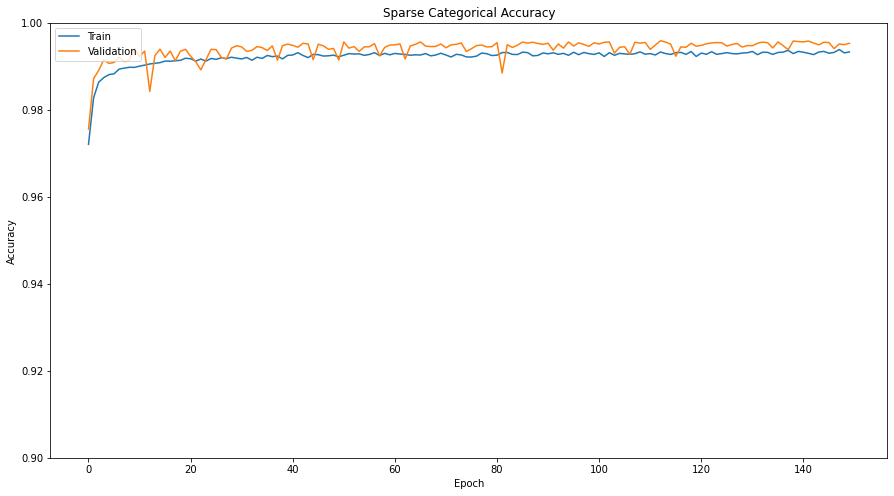

In [136]:
# summarize history for accuracy
# plt.plot(history.history['loss'])
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('Sparse Categorical Accuracy')
plt.ylim(0.9, 1) 
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

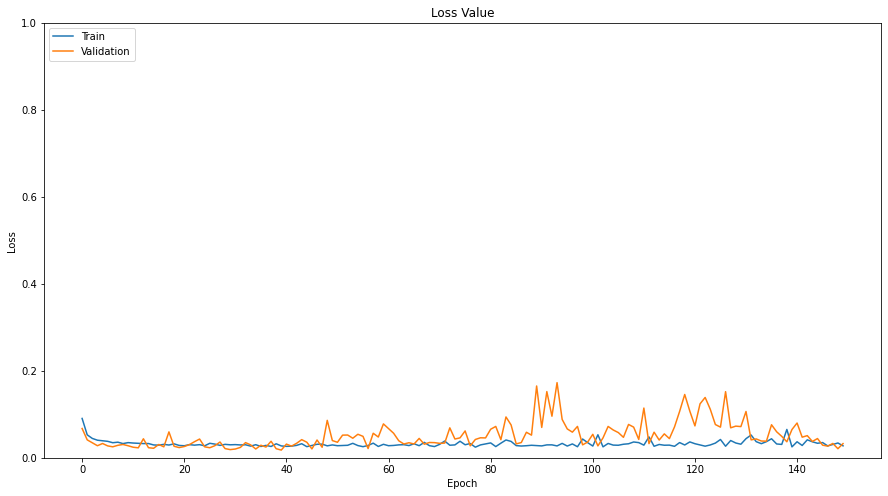

In [138]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Value')
plt.ylim(0, 1) 
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

**Evaluation on testing test:**

Create testing dataset:

In [131]:
df_test = normalize(df_test)  # Normalize the test dataset
df_test = create_dataset(df_test, top_columns)  # Feature Extraction
y_test = df_test['attack_type']  # Label # Series
X_test = df_test.drop(['attack_type'], axis='columns')  # Features # Dataframe

Evaluate accuracy:

In [132]:
score = model.evaluate(X_test, y_test)

705/705 [==============================] - 2s 3ms/step - loss: 28.5823 - sparse_categorical_accuracy: 0.7611


In [133]:
y_predict = model.predict(X_test)

### Save the weighted model to Drive

In [154]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [155]:
path = '/content/gdrive/My Drive/20192/model/'  # Path to save files
h5_path = '/content/gdrive/My Drive/20192/model/model.h5'

In [156]:
model.save(path)
model.save(h5_path)

INFO:tensorflow:Assets written to: /content/gdrive/My Drive/20192/model/assets


Load model:

In [147]:
loaded_model = keras.models.load_model(path)

In [148]:
loaded_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 1024)              26624     
_________________________________________________________________
dropout_10 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 768)               787200    
_________________________________________________________________
dropout_11 (Dropout)         (None, 768)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 512)               393728    
_________________________________________________________________
dropout_12 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 256)              

In [149]:
loaded_score = loaded_model.evaluate(X_test, y_test)

705/705 [==============================] - 2s 3ms/step - loss: 28.5823 - sparse_categorical_accuracy: 0.7611
